## 2D Navier-Stokes Solver ##

The Navier-Stokes Equations are: 
$$ \frac{d\textbf{u}}{dt} + (\textbf{u} \cdot \nabla ) \textbf{u} = - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u} + \textbf{f} $$
$$ \nabla \cdot \textbf{u} = 0 $$

Where: 

*   $\rho$ is density,

*   $\textbf{u}$ is velocity,
*   $p$ is pressure, 
*   $\nu$ is kinematic viscosity,
*   $\textbf{f}$ is the sum of all external forces. 

We cannot use the standard Euler's method for numerical ODE's because this will not ensure that the second equation is satisfied. It also only gives us an equation for the velocity, and not one for the pressure.

Method of solution is presented here: 
http://hplgit.github.io/INF5620/doc/pub/main_ns.pdf

I have also used the implementation presented here for guidance: https://www.youtube.com/watch?v=BQLvNLgMTQE

We are setting force to 0. Essentially we use the following approach, with timestep $dt$: 

1.   Find an intermidiate velocity $ \textbf{u}^* $ from the first Navier-Stokes Equation using: $$ \textbf{u}^* = \textbf{u}^n  - dt (\textbf{u}^n \cdot \nabla  ) \textbf{u}^n + dt \, \nu \nabla^2 \textbf{u}^n $$
2.   Solve the following equation for pressure: $$ \nabla^2 p^{n+1}  = \frac{\rho}{dt} \nabla \cdot \textbf{u}^*. $$ For this, we can use standard numerical methods, i.e. Euler's method. 
3.   Update velocity using: $$ \textbf{u}^{n+1} = \textbf{u}^* - \frac{dt}{\rho} \nabla p^{n+1} $$


Information for estimating derivatives and Laplacian are [here](https://www.math.uci.edu/~chenlong/226/FDM.pdf).



In [1]:
#!pip install gstools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gstools as gs
import imageio
from google.colab import drive

In [3]:
# Constants:
N_POINTS = 64
DOMAIN_SIZE = 1.0
N_ITERATIONS = 500
KINEMATIC_VISCOSITY = 0.1
DENSITY = 0.5
dt = 0.001
element_length = DOMAIN_SIZE / (N_POINTS - 1)

N_PRESSURE_POISSON_ITERATIONS = 50

In [4]:
# This is the function that generates our divergence free vector field for the velocity.

def k2g_fft(kE, kB, dx, pad=True):
    """
    Convert kappa to gamma in Fourier space. If padding is
    set to True, include the same size of padding as the data
    on each side, the total grid is 9 times the original.
    """

    if pad:
        kE_temp = np.zeros((len(kE)*3, len(kE[0])*3))
        kB_temp = np.zeros((len(kB)*3, len(kE[0])*3))
        kE_temp[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2] = kE*1.0
        kB_temp[len(kB):len(kB)*2, len(kB[0]):len(kB[0])*2] = kB*1.0
        kE_3d_ft = np.fft.fft2(kE_temp)
        kB_3d_ft = np.fft.fft2(kB_temp)
    else:
        kE_3d_ft = np.fft.fft2(kE)
        kB_3d_ft = np.fft.fft2(kB)
   
    FF1 = np.fft.fftfreq(len(kE_3d_ft))
    FF2 = np.fft.fftfreq(len(kE_3d_ft[0]))

    dk = 1.0/dx*2*np.pi                     # max delta_k in 1/arcmin
    kx = np.dstack(np.meshgrid(FF2, FF1))[:,:,0]*dk
    ky = np.dstack(np.meshgrid(FF2, FF1))[:,:,1]*dk
    kx2 = kx**2
    ky2 = ky**2
    k2 = kx2 + ky2

    k2[k2==0] = 1e-15
    k2gamma1_ft = kE_3d_ft/k2*(kx2-ky2) - kB_3d_ft/k2*2*(kx*ky)
    k2gamma2_ft = kE_3d_ft/k2*2*(kx*ky) + kB_3d_ft/k2*(kx2-ky2)

    if pad:
        return np.fft.ifft2(k2gamma1_ft).real[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2], np.fft.ifft2(k2gamma2_ft).real[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2]
    else:
        return np.fft.ifft2(k2gamma1_ft).real, np.fft.ifft2(k2gamma2_ft).real

In [5]:
def compute_spectrum_map(power1d,size):
    """
    takes 1D power spectrum and makes it an isotropic 2D map
    :param power: 1d power spectrum
    :param size:
    :return:
    """

    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j] == 0:
            power_map[i, j] = 1e-15
        else:
            power_map[i, j] = power1d[int(k_map[i, j])]

    return power_map



def gaussian_mock(spectrum_map_flat_sqrt,image_size):
    gaussian_field = np.random.normal(0, spectrum_map_flat_sqrt) + 1j*np.random.normal(0, spectrum_map_flat_sqrt)
    gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_field.reshape((image_size,image_size)))).imag
    return gaussian_field

In [6]:
karray = np.arange(N_POINTS)
pk = np.exp(-karray * karray / 5)

spectrum_map = compute_spectrum_map(pk, N_POINTS)

field = gaussian_mock(spectrum_map.flatten(), N_POINTS).T

In [7]:
#model = gs.Gaussian(dim=2, var=1, len_scale=int(N_POINTS/10))
#srf = gs.SRF(model, seed= int(time.time()))
 
#field = srf.structured([range(N_POINTS), range(N_POINTS)])

In [8]:
# u1, u2 = k2g_fft(field*0, field, dx=1, pad=True)

# plt.quiver(X[::2, ::2], Y[::2, ::2], u1[::2, ::2], u2[::2, ::2], color="white")
# # plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
# plt.show()

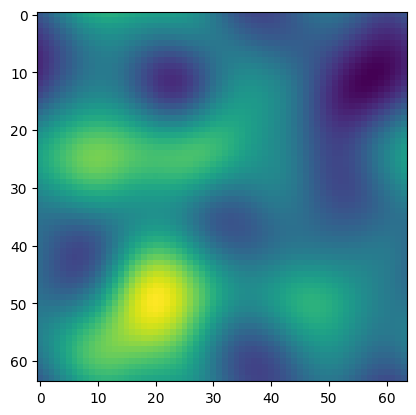

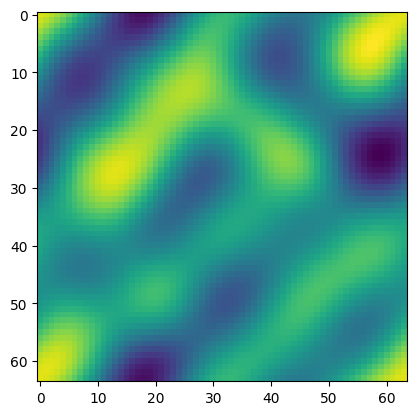

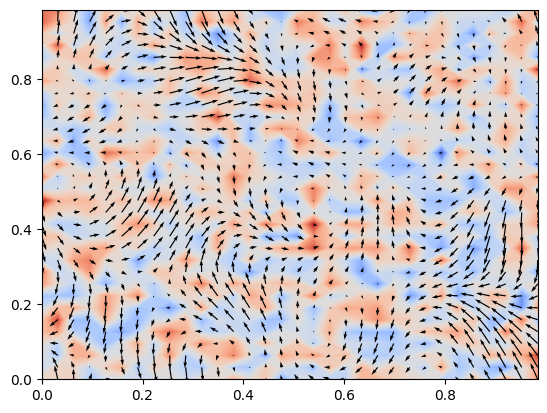

In [9]:
# Define our x and y grid, and the velocities u and v in the x and y directions respectively, and pressure.  
x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

X, Y = np.meshgrid(x, y)

p_prev = 0.1* np.random.normal(size= X.shape)

force_x = np.zeros_like(X)
force_y = np.zeros_like(X)

# force_x[:, 0] = 10 * np.ones_like(X[:, 0])
# force_x[:, -1] = 10 * np.ones_like(X[:, -1])
# force_y[0, :] = 10 * np.ones_like(X[0, :])
# force_y[-1, :] = 10 * np.ones_like(X[-1, :])

v_prev, u_prev = k2g_fft(field*0, field, dx=1, pad=False)

#print(d_dx(u_prev) + d_dy(v_prev))

# p_prev[:, :20] = 10 * np.ones_like(X[:, :20])
# p_prev[:, 20:] = 30 * np.ones_like(X[:, 20:])

plt.imshow(u_prev), plt.show()
plt.imshow(v_prev), plt.show()

plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], 100, cmap="coolwarm")
plt.quiver(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2], color="black")
plt.show()


In [10]:
# Define our derivatives in each direction, plus the Laplacian:
# d_dx at f(0,0) is essentially [ f(1,0) - f(-1,0) ] / element_length, since element length is the distance between points, and d_dy is identical. 
# This is a central difference derivative estimate. 
# Since we are wrapping around at the boundaries, this makes calculations easier later. 

# Note that we use the second position as the x coordinate and the first as the y as it is a matrix, so column comes before row. 
def d_dx(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[:, 0] = (f[:, 1] - f[:, -1]) / ( 2 * element_length)   #LHS
  diff[:, -1] = (f[:, 0] - f[:, -2]) / ( 2 * element_length)   #RHS

  #Interior points
  diff[:, 1:-1] = (f[:, 2:  ] - f[:, 0:-2] ) / ( 2 * element_length)

  return diff

def d_dy(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[0, :] = (f[1, :] - f[-1, :]) / ( 2 * element_length)   #TOP
  diff[-1, :] = (f[0, :] - f[-2, :]) / ( 2 * element_length)   #BOTTOM

  #Interior points
  diff[1:-1, :] = (f[2:, :  ] - f[0:-2, :] ) / ( 2 * element_length)

  return diff

def d2_dx2(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -1]) / (element_length**2)   #LHS
  diff[:, -1] = (f[:, 0] - 2 * f[:, -1] + f[:, -2]) / (element_length**2)   #RHS

  #Interior points
  diff[:, 1:-1] = (f[:, 2:  ] - 2 * f[:, 1:-1] + f[:, 0:-2] ) / (element_length**2)

  return diff

def d2_dy2(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[0, :] = (f[1, :] - 2 * f[0, :] + f[-1, :]) / ( 2 * element_length)   #TOP
  diff[-1, :] = (f[0, :] - 2 * f[-1, :] + f[-2, :]) / ( 2 * element_length)   #BOTTOM

  #Interior points
  diff[1:-1, :] = (f[2:, :  ] - 2 * f[1:-1, :] + f[0:-2, :] ) / ( 2 * element_length)

  return diff


def laplacian(f):
  # return d_dx(d_dx(u)) + d_dy(d_dy(v)) This is a bad estimate. 
  return d2_dx2(f) + d2_dy2(f) 
  

Our intermediate velocity is: $$ \textbf{u}^* = \textbf{u}^n  - dt (\textbf{u}^n \cdot \nabla  ) \textbf{u}^n + dt \, \nu \nabla^2 \textbf{u}^n $$
Writing this out in terms of our individual components $u$ and $v,$ we get:
$$ \begin{align} u^* & = u - dt \left( u \frac{\partial u}{\partial x} + v \frac{ \partial u}{\partial y} \right) + dt \, \nu \nabla^2 u \\ v^* & = v - dt \left( u \frac{\partial v}{\partial x} + v \frac{ \partial v}{\partial y} \right) + dt \, \nu \nabla^2 v \end{align} $$

In [11]:
def u_intermediate(u, v):
  return u - dt * (np.multiply(u, d_dx(u)) + np.multiply(v, d_dy(u))) + dt * KINEMATIC_VISCOSITY * laplacian(u) + dt * force_x
def v_intermediate(u, v):
  return v - dt * (np.multiply(u, d_dx(v)) + np.multiply(v, d_dy(v))) + dt * KINEMATIC_VISCOSITY * laplacian(v) + dt * force_y

### Poisson Equation Solution

Our Poisson Equation is: 
$$ \nabla^2 p^{n+1}  = \frac{\rho}{dt} \nabla \cdot \textbf{u}^*. $$
Also recall that our 5 point estimate for the Laplacian is:
$$ \nabla^2 p(0, 0) = \frac{p(0,-1) + p(0, 1) + p(1, 0) + p(-1, 0) - 4 p(0, 0)}{\epsilon^2} $$
Where $\epsilon$ is element_length. Plugging this into the Poisson equation and rearranging gives:
$$ p(0,0) = \frac{1}{4} \left(p(0,-1) + p(0, 1) + p(1, 0) + p(-1, 0) - \epsilon^2 \frac{\rho}{dt} \nabla \cdot \textbf{u}^*(0, 0) \right) $$ 

Which gives us an estimate for pressure at each point. We can use a reccursive process to find this more accurately each time. 

In [12]:
def p_update(u, v, p_prev):
  # Define the right hand side of the poisson equation. 
  rhs = KINEMATIC_VISCOSITY / dt * (d_dx(u) + d_dy(v))

  # Iterate and correct. 
  for i in range(N_PRESSURE_POISSON_ITERATIONS):
    p_next = np.zeros_like(p_prev)

    # First add all of the previous pressure terms.
    p_next[:, 0] = p_next[:, 0] + p_prev[:, 1] + p_prev[:, -1]         #LHS
    p_next[:, -1] = p_next[:, 0] + p_prev[:, 0] + p_prev[:, -2]        #RHS
    p_next[:, 1:-1] = p_next[:, 1:-1] + p_prev[:, 2:  ] + p_prev[:, 0:-2] #Interior horizontal points
    p_next[0, :] = p_next[0, :] + p_prev[1, :] + p_prev[-1, :]         #TOP
    p_next[-1, :] = p_next[-1, :] + p_prev[0, :] + p_prev[-2, :]        #BOTTOM
    p_next[1:-1, :] = p_next[1:-1, :] + p_prev[2:, :  ] - p_prev[0:-2, :] #Interior verticle points.

    #Now subtract the RHS term from all points.
    p_next = p_next - element_length**2 * rhs

    #Finally, divide by 4.
    p_next = 0.25 * p_next

    p_prev = p_next

    

  return p_prev

### Final velocity update
Now we need to add our final velocity updating term. 
$$ \textbf{u}^{n+1} = \textbf{u}^* - \frac{dt}{\rho} \nabla p^{n+1} $$
This is straightforward.

In [13]:
def u_update(u, p):
  return (u - dt / KINEMATIC_VISCOSITY * d_dx(p))

def v_update(v, p):
  return (v - dt / KINEMATIC_VISCOSITY * d_dy(p))

We have now made all of our required functions. We can thus make the iterated process:

[[ 0.00212418  0.0005316  -0.00026647 ...  0.00282079  0.00329031
   0.00355517]
 [-0.00063325 -0.00130425 -0.0020833  ...  0.00366267  0.00190241
   0.0001318 ]
 [-0.00131445 -0.00306058 -0.00370734 ...  0.00100877  0.00076989
   0.00080961]
 ...
 [ 0.00807865  0.00729738  0.0061155  ...  0.0092236   0.00904654
   0.00850822]
 [ 0.00664929  0.00516188  0.00396021 ...  0.00727591  0.00771677
   0.00792373]
 [ 0.0050205   0.0028704   0.00176463 ...  0.0037103   0.00544432
   0.00693627]]


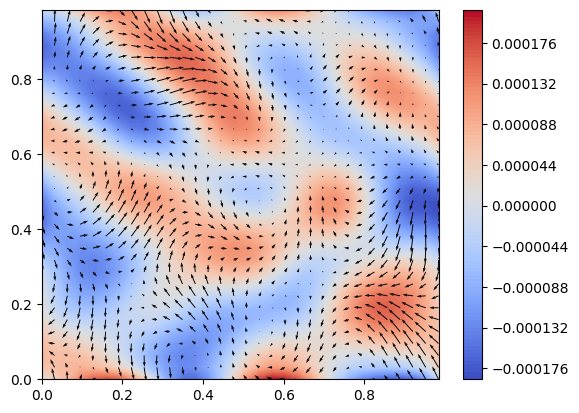

[[-8.19134892e-04 -2.13430863e-04 -1.35895680e-04 ... -3.79770089e-04
  -9.03143616e-04 -1.42407764e-03]
 [ 1.71049173e-03  1.00795883e-03  4.17299729e-04 ...  2.91854972e-03
   2.67881645e-03  2.42270911e-03]
 [ 8.32781835e-04 -5.80600137e-05 -7.05371342e-04 ...  2.07273499e-03
   1.91506961e-03  1.69211287e-03]
 ...
 [ 5.38453038e-03  5.82195933e-03  5.24392573e-03 ...  6.77634072e-03
   5.86088830e-03  4.89819764e-03]
 [ 4.44065749e-03  4.55420656e-03  3.86089180e-03 ...  6.04445596e-03
   5.19009049e-03  4.25322042e-03]
 [-6.71962784e-04  3.16936015e-04  3.26669538e-04 ...  3.16537622e-04
  -6.72474784e-04 -1.68884145e-03]]


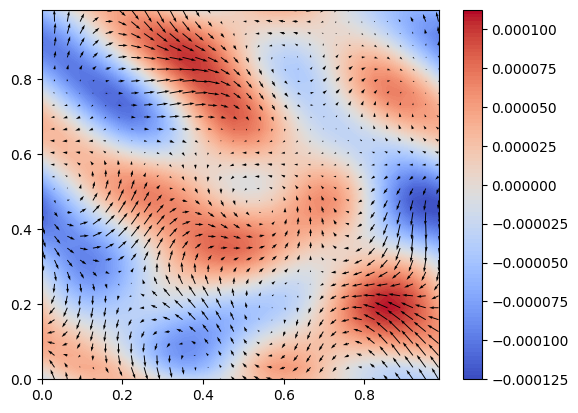

[[-5.62631134e-04 -6.96018978e-05 -3.05000541e-05 ... -1.43505658e-04
  -5.99985984e-04 -1.05844801e-03]
 [ 1.39429753e-03  1.07901651e-03  7.99506453e-04 ...  1.89666053e-03
   1.80865268e-03  1.72603620e-03]
 [ 7.38824469e-04  3.54960332e-04  7.20822447e-05 ...  1.18150305e-03
   1.15889955e-03  1.11303258e-03]
 ...
 [ 3.66186437e-03  4.07887843e-03  3.80876562e-03 ...  4.43872390e-03
   3.84004098e-03  3.23805302e-03]
 [ 3.13592816e-03  3.37945812e-03  3.03679455e-03 ...  4.01837150e-03
   3.45639174e-03  2.86217525e-03]
 [-6.32093574e-04  1.19099509e-04  1.39441612e-04 ...  1.07970698e-04
  -6.37806884e-04 -1.40053625e-03]]


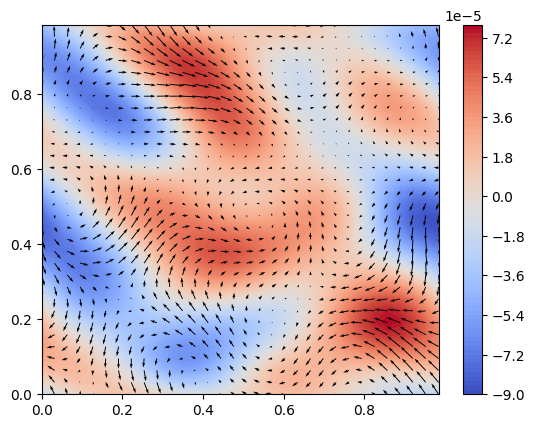

[[-4.23256832e-04 -2.80726825e-05 -2.49691842e-06 ... -6.96651131e-05
  -4.44301858e-04 -8.19443282e-04]
 [ 1.08846340e-03  9.70010103e-04  8.49621765e-04 ...  1.26181852e-03
   1.23645840e-03  1.22435713e-03]
 [ 6.50893944e-04  4.96852144e-04  3.74569781e-04 ...  7.69718750e-04
   7.90103829e-04  8.00946611e-04]
 ...
 [ 2.57847410e-03  2.95296023e-03  2.84056674e-03 ...  2.98304301e-03
   2.59093516e-03  2.21109557e-03]
 [ 2.26228958e-03  2.53471321e-03  2.37169155e-03 ...  2.73462046e-03
   2.36144062e-03  1.97767672e-03]
 [-5.19320468e-04  5.40321011e-05  7.14321512e-05 ...  4.33257736e-05
  -5.24777724e-04 -1.10436670e-03]]


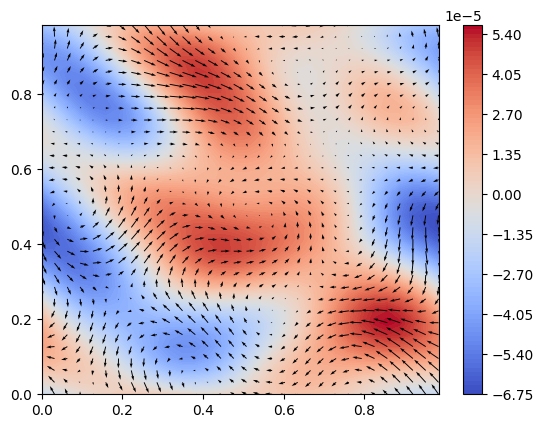

[[-3.24437071e-04 -9.20763571e-06  8.36695969e-06 ... -3.31245024e-05
  -3.36541390e-04 -6.39921149e-04]
 [ 8.51642629e-04  8.32049998e-04  7.95671971e-04 ...  8.53993640e-04
   8.62929610e-04  8.87755388e-04]
 [ 5.49155963e-04  5.12256478e-04  4.74612541e-04 ...  5.08662487e-04
   5.48087550e-04  5.85601952e-04]
 ...
 [ 1.87752902e-03  2.19862355e-03  2.16509481e-03 ...  2.07601211e-03
   1.81350912e-03  1.56826414e-03]
 [ 1.66805069e-03  1.92810565e-03  1.86063644e-03 ...  1.90672044e-03
   1.65575130e-03  1.40462912e-03]
 [-4.15008355e-04  2.68520096e-05  4.03866826e-05 ...  1.90188413e-05
  -4.18986603e-04 -8.65534880e-04]]


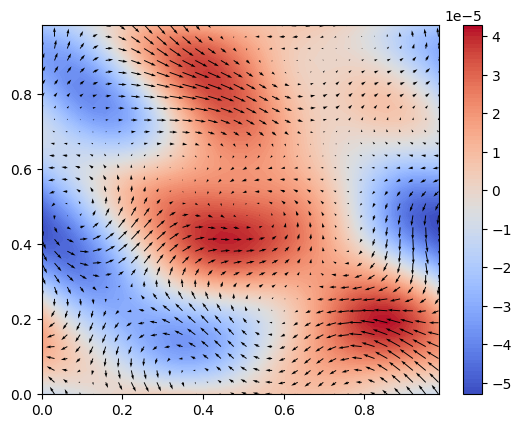

[[-2.56342856e-04 -1.72170618e-07  1.25695713e-05 ... -1.44642362e-05
  -2.63576046e-04 -5.12449882e-04]
 [ 6.80249756e-04  7.10200647e-04  7.17359713e-04 ...  5.99086232e-04
   6.24179729e-04  6.65559915e-04]
 [ 4.64727541e-04  4.88514445e-04  4.95034729e-04 ...  3.50668658e-04
   3.95535457e-04  4.42697591e-04]
 ...
 [ 1.41624955e-03  1.68716252e-03  1.69142721e-03 ...  1.50558552e-03
   1.32303613e-03  1.15838951e-03]
 [ 1.26522795e-03  1.49949094e-03  1.48153560e-03 ...  1.37637000e-03
   1.20190573e-03  1.03210950e-03]
 [-3.33392314e-04  1.54091772e-05  2.56892923e-05 ...  1.02885003e-05
  -3.35980526e-04 -6.89054778e-04]]


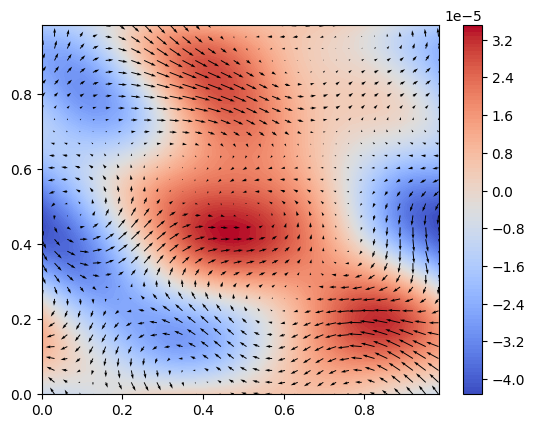

[[-2.10316197e-04  4.12151426e-06  1.38917776e-05 ... -4.76160979e-06
  -2.14812002e-04 -4.24518357e-04]
 [ 5.60167799e-04  6.14373710e-04  6.42993381e-04 ...  4.43085231e-04
   4.73694029e-04  5.20048215e-04]
 [ 4.02126497e-04  4.57208635e-04  4.85701058e-04 ...  2.59993460e-04
   3.02821782e-04  3.50213376e-04]
 ...
 [ 1.10734248e-03  1.33630530e-03  1.35750534e-03 ...  1.14013913e-03
   1.00725935e-03  8.91236666e-04]
 [ 9.91037250e-04  1.19812761e-03  1.20491813e-03 ...  1.03441016e-03
   9.07564506e-04  7.87377352e-04]
 [-2.73424512e-04  1.07999015e-05  1.86979139e-05 ...  7.52609427e-06
  -2.75069122e-04 -5.63334935e-04]]


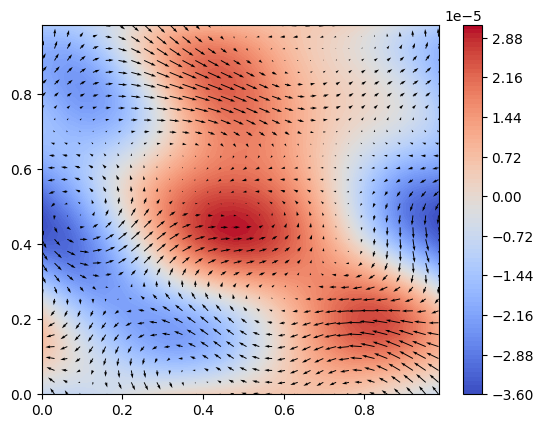

[[-1.79242142e-04  6.01422415e-06  1.39194911e-05 ...  2.84546706e-07
  -1.82142172e-04 -3.64126823e-04]
 [ 4.76458280e-04  5.41929092e-04  5.80099496e-04 ...  3.48534128e-04
   3.78867432e-04  4.24066134e-04]
 [ 3.57596849e-04  4.28411634e-04  4.66738999e-04 ...  2.10896468e-04
   2.48008076e-04  2.90845138e-04]
 ...
 [ 8.95290290e-04  1.09088463e-03  1.11873029e-03 ...  8.99302245e-04
   7.97911327e-04  7.11825185e-04]
 [ 8.01613148e-04  9.84481670e-04  1.00295625e-03 ...  8.09848956e-04
   7.12928663e-04  6.23275780e-04]
 [-2.30244140e-04  9.08873098e-06  1.53355260e-05 ...  6.92261973e-06
  -2.31325301e-04 -4.74425636e-04]]


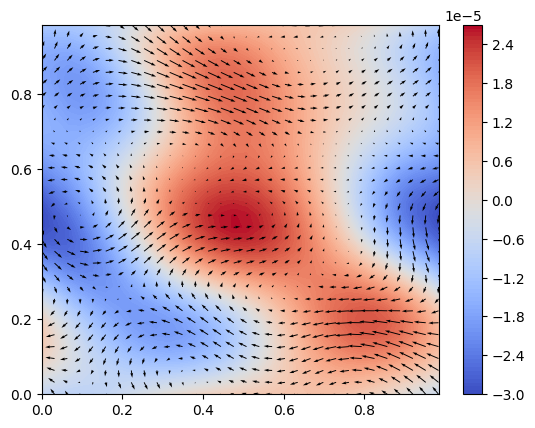

[[-1.57846682e-04  6.68891241e-06  1.33880917e-05 ...  2.86542075e-06
  -1.59782067e-04 -3.21881662e-04]
 [ 4.17131999e-04  4.87134207e-04  5.28533562e-04 ...  2.91002648e-04
   3.18221059e-04  3.59350095e-04]
 [ 3.25826942e-04  4.03981410e-04  4.45611771e-04 ...  1.86002422e-04
   2.16012395e-04  2.52281423e-04]
 ...
 [ 7.45134561e-04  9.14558704e-04  9.44118097e-04 ...  7.34881686e-04
   6.54054346e-04  5.86964398e-04]
 [ 6.67539759e-04  8.30043226e-04  8.53423837e-04 ...  6.58207951e-04
   5.80502294e-04  5.10033879e-04]
 [-1.98983007e-04  8.51570607e-06  1.36322396e-05 ...  6.98621851e-06
  -1.99742485e-04 -4.10687446e-04]]


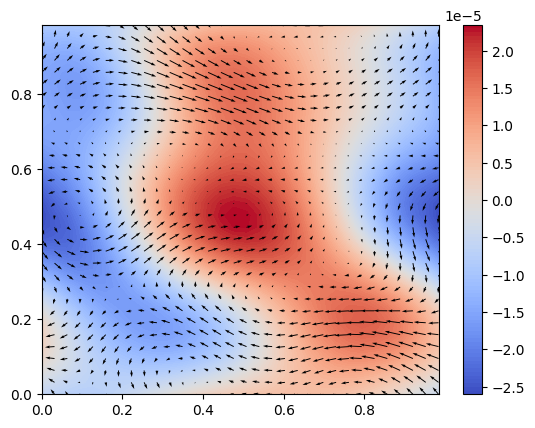

[[-1.42530135e-04  6.75718462e-06  1.26432111e-05 ...  4.12209289e-06
  -1.43864017e-04 -2.91195777e-04]
 [ 3.73660678e-04  4.44634187e-04  4.85982747e-04 ...  2.55251424e-04
   2.78213010e-04  3.14161607e-04]
 [ 3.02306419e-04  3.83154603e-04  4.24664437e-04 ...  1.74318806e-04
   1.97128604e-04  2.26374688e-04]
 ...
 [ 6.35101849e-04  7.83884299e-04  8.12882089e-04 ...  6.18199036e-04
   5.51289007e-04  4.96709039e-04]
 [ 5.69705682e-04  7.15343285e-04  7.40166929e-04 ...  5.52217681e-04
   4.87237847e-04  4.29194908e-04]
 [-1.75826649e-04  8.32587743e-06  1.26579610e-05 ...  7.16956157e-06
  -1.76399234e-04 -3.63666260e-04]]


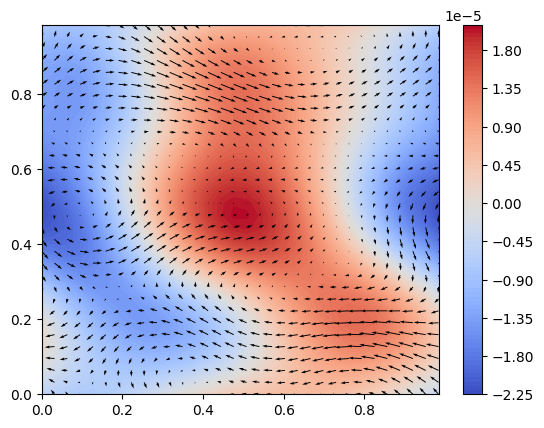

[[-1.30971685e-04  6.53362331e-06  1.18416918e-05 ...  4.65825023e-06
  -1.31920945e-04 -2.67748946e-04]
 [ 3.40375081e-04  4.10383399e-04  4.50043595e-04 ...  2.32077237e-04
   2.50561743e-04  2.81175754e-04]
 [ 2.83824539e-04  3.64708690e-04  4.04382297e-04 ...  1.69258622e-04
   1.85423243e-04  2.07999489e-04]
 ...
 [ 5.51663549e-04  6.83899990e-04  7.11353279e-04 ...  5.32142542e-04
   4.75020596e-04  4.29020252e-04]
 [ 4.95913300e-04  6.27508287e-04  6.52042041e-04 ...  4.75304779e-04
   4.19079929e-04  3.69397420e-04]
 [-1.58084445e-04  8.21955932e-06  1.19897722e-05 ...  7.29858124e-06
  -1.58540277e-04 -3.27645076e-04]]


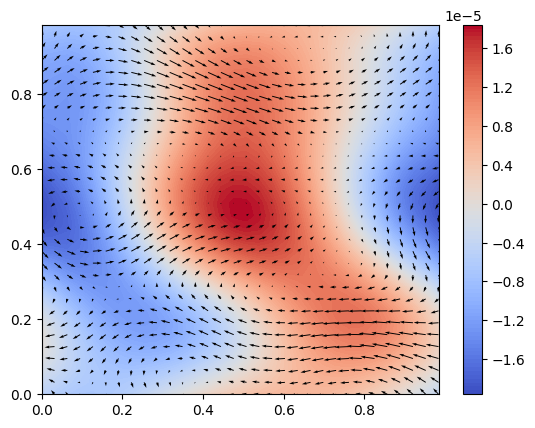

[[-1.21731846e-04  6.17816413e-06  1.10501747e-05 ...  4.79872882e-06
  -1.22429962e-04 -2.48827255e-04]
 [ 3.13655828e-04  3.81614154e-04  4.18828501e-04 ...  2.16054302e-04
   2.30304763e-04  2.55898591e-04]
 [ 2.68307872e-04  3.47655949e-04  3.84705956e-04 ...  1.67069829e-04
   1.77422037e-04  1.94046931e-04]
 ...
 [ 4.86347124e-04  6.05044521e-04  6.30586735e-04 ...  4.66370148e-04
   4.16399693e-04  3.76527302e-04]
 [ 4.38412721e-04  5.58145447e-04  5.81553364e-04 ...  4.17372725e-04
   3.67430224e-04  3.23620426e-04]
 [-1.43960427e-04  8.09295393e-06  1.14436454e-05 ...  7.33649019e-06
  -1.44335217e-04 -2.98907650e-04]]


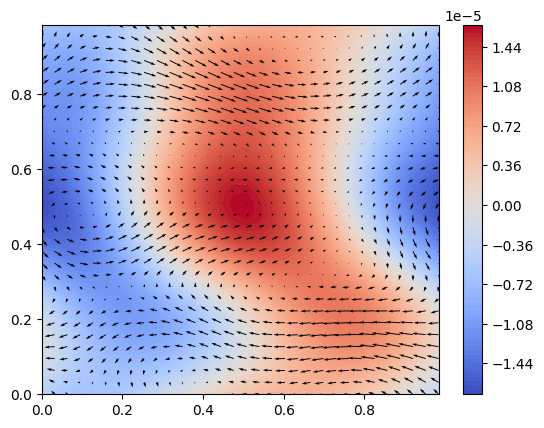

[[-1.13940528e-04  5.77136072e-06  1.02941566e-05 ...  4.72194130e-06
  -1.14471484e-04 -2.32772968e-04]
 [ 2.91245052e-04  3.56534915e-04  3.91013813e-04 ...  2.04042045e-04
   2.14505039e-04  2.35590945e-04]
 [ 2.54505490e-04  3.31364620e-04  3.65501663e-04 ...  1.65730982e-04
   1.71171669e-04  1.82681770e-04]
 ...
 [ 4.33753835e-04  5.41134318e-04  5.64685477e-04 ...  4.14491358e-04
   3.69936895e-04  3.34611965e-04]
 [ 3.92245478e-04  5.01782932e-04  5.23692342e-04 ...  3.72194874e-04
   3.26959755e-04  2.87464727e-04]
 [-1.32290178e-04  7.92015033e-06  1.09434145e-05 ...  7.29019023e-06
  -1.32602830e-04 -2.75085862e-04]]


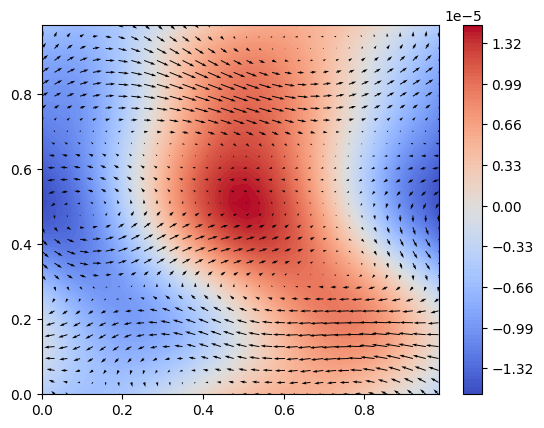

[[-1.07080192e-04  5.35360519e-06  9.58156758e-06 ...  4.52819695e-06
  -1.07497667e-04 -2.18590726e-04]
 [ 2.71748669e-04  3.34022001e-04  3.65721616e-04 ...  1.94248837e-04
   2.01434107e-04  2.18578909e-04]
 [ 2.41704611e-04  3.15494623e-04  3.46691455e-04 ...  1.64231367e-04
   1.65621869e-04  1.72842963e-04]
 ...
 [ 3.90358819e-04  4.88090250e-04  5.09698858e-04 ...  3.72439529e-04
   3.32124045e-04  3.00293687e-04]
 [ 3.54187356e-04  4.54814285e-04  4.75091297e-04 ...  3.35851030e-04
   2.94294456e-04  2.58112696e-04]
 [-1.22327629e-04  7.70249082e-06  1.04594487e-05 ...  7.17606551e-06
  -1.22589396e-04 -2.54679049e-04]]


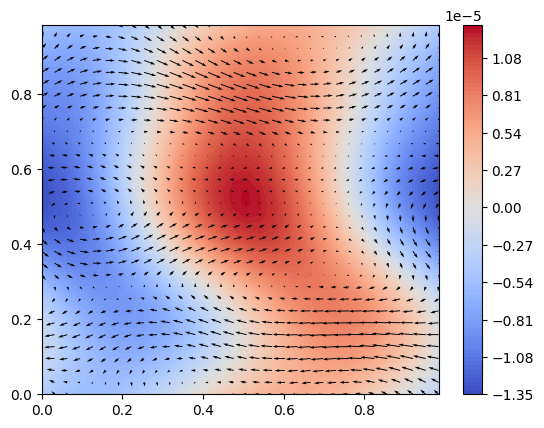

[[-1.00845557e-04  4.94510297e-06  8.91345582e-06 ...  4.27521170e-06
  -1.01184245e-04 -2.05687960e-04]
 [ 2.54305790e-04  3.13381410e-04  3.42384177e-04 ...  1.85665360e-04
   1.90074680e-04  2.03828833e-04]
 [ 2.29521982e-04  2.99900005e-04  3.28262956e-04 ...  1.62126261e-04
   1.60240223e-04  1.63927283e-04]
 ...
 [ 3.53795288e-04  4.43155227e-04  4.62923916e-04 ...  3.37539350e-04
   3.00643207e-04  2.71585307e-04]
 [ 3.22094230e-04  4.14818571e-04  4.33452122e-04 ...  3.05806500e-04
   2.67239295e-04  2.33709871e-04]
 [-1.13594159e-04  7.44859955e-06  9.98128552e-06 ...  7.00936915e-06
  -1.13812973e-04 -2.36730749e-04]]


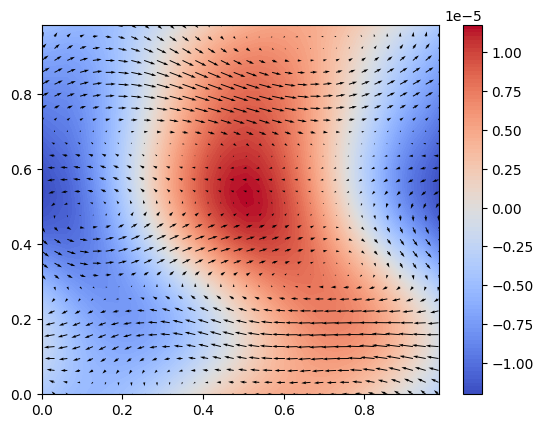

[[-9.50569266e-05  4.55583870e-06  8.28847059e-06 ...  3.99679831e-06
  -9.53394625e-05 -1.93712403e-04]
 [ 2.38380060e-04  2.94185646e-04  3.20635989e-04 ...  1.77730645e-04
   1.79825388e-04  1.90691813e-04]
 [ 2.17766042e-04  2.84547827e-04  3.10247161e-04 ...  1.59273641e-04
   1.54781760e-04  1.55596937e-04]
 ...
 [ 3.22428702e-04  4.04417881e-04  4.22469196e-04 ...  3.07971934e-04
   2.73911914e-04  2.47119572e-04]
 [ 2.94503655e-04  3.80134073e-04  3.97175898e-04 ...  2.80373854e-04
   2.44323639e-04  2.12999834e-04]
 [-1.05779166e-04  7.16750546e-06  9.50603661e-06 ...  6.80215480e-06
  -1.05961481e-04 -2.20622359e-04]]


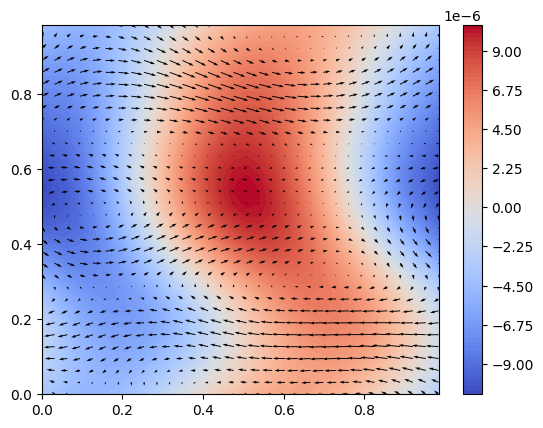

[[-8.96082954e-05  4.19049316e-06  7.70455978e-06 ...  3.71291001e-06
  -8.98495792e-05 -1.82453768e-04]
 [ 2.23632063e-04  2.76169152e-04  3.00238869e-04 ...  1.70139023e-04
   1.70328429e-04  1.78752204e-04]
 [ 2.06351723e-04  2.69462831e-04  2.92695239e-04 ...  1.55684077e-04
   1.49155674e-04  1.47666003e-04]
 ...
 [ 2.95101168e-04  3.70521450e-04  3.86982477e-04 ...  2.82464321e-04
   2.50818349e-04  2.25929569e-04]
 [ 2.70392848e-04  3.49593620e-04  3.65126891e-04 ...  2.58397644e-04
   2.24534070e-04  1.95107741e-04]
 [-9.86772154e-05  6.86686907e-06  9.03374148e-06 ...  6.56376075e-06
  -9.88286959e-05 -2.05945384e-04]]


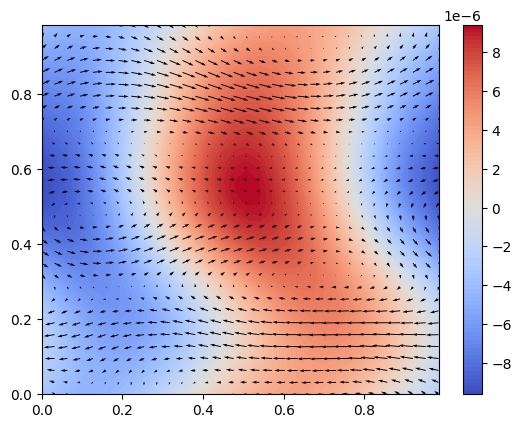

[[-8.44368458e-05  3.85088290e-06  7.15952501e-06 ...  3.43520284e-06
  -8.46467924e-05 -1.71785497e-04]
 [ 2.09842664e-04  2.59163913e-04  2.81033522e-04 ...  1.62729999e-04
   1.61369859e-04  1.67738180e-04]
 [ 1.95250302e-04  2.54693805e-04  2.75662376e-04 ...  1.51438254e-04
   1.43350448e-04  1.40034765e-04]
 ...
 [ 2.70974883e-04  3.40483032e-04  3.55478649e-04 ...  2.60104958e-04
   2.30563332e-04  2.07316328e-04]
 [ 2.49030296e-04  3.22359627e-04  3.36482271e-04 ...  2.39067340e-04
   2.07155154e-04  1.79410034e-04]
 [-9.21492136e-05  6.55291544e-06  8.56559536e-06 ...  6.30169243e-06
  -9.22749277e-05 -1.92423540e-04]]


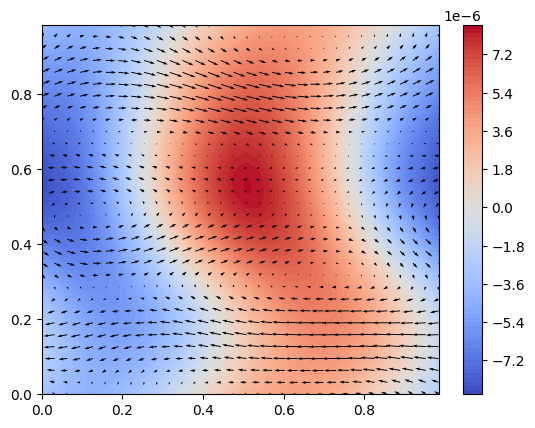

[[-7.95051930e-05  3.53720844e-06  6.65116595e-06 ...  3.17023495e-06
  -7.96904948e-05 -1.61630633e-04]
 [ 1.96867209e-04  2.43060709e-04  2.62909410e-04 ...  1.55425844e-04
   1.52821922e-04  1.57468596e-04]
 [ 1.84461021e-04  2.40294987e-04  2.59198664e-04 ...  1.46643429e-04
   1.37392910e-04  1.32652268e-04]
 ...
 [ 2.49433384e-04  3.13578517e-04  3.27228480e-04 ...  2.40230198e-04
   2.12562700e-04  1.90766169e-04]
 [ 2.29882913e-04  2.97819695e-04  3.10635266e-04 ...  2.21803642e-04
   1.91672196e-04  1.65453962e-04]
 [-8.60986100e-05  6.23076410e-06  8.10328018e-06 ...  6.02228384e-06
  -8.62030537e-05 -1.79865352e-04]]


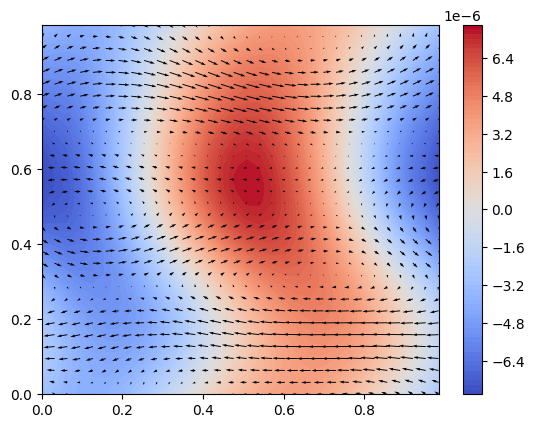

[[-7.47910356e-05  3.24873143e-06  6.17730767e-06 ...  2.92138375e-06
  -7.49562980e-05 -1.51941834e-04]
 [ 1.84608016e-04  2.27785997e-04  2.45786322e-04 ...  1.48196166e-04
   1.44609419e-04  1.47820895e-04]
 [ 1.73995582e-04  2.26316788e-04  2.43344981e-04 ...  1.41411550e-04
   1.31326401e-04  1.25495061e-04]
 ...
 [ 2.30017040e-04  2.89267045e-04  3.01684736e-04 ...  2.22351488e-04
   1.96384424e-04  1.75896976e-04]
 [ 2.12556288e-04  2.75518916e-04  2.87131426e-04 ...  2.06187053e-04
   1.77709805e-04  1.52906199e-04]
 [-8.04567487e-05  5.90473143e-06  7.64868168e-06 ...  5.73106810e-06
  -8.05438355e-05 -1.68135024e-04]]


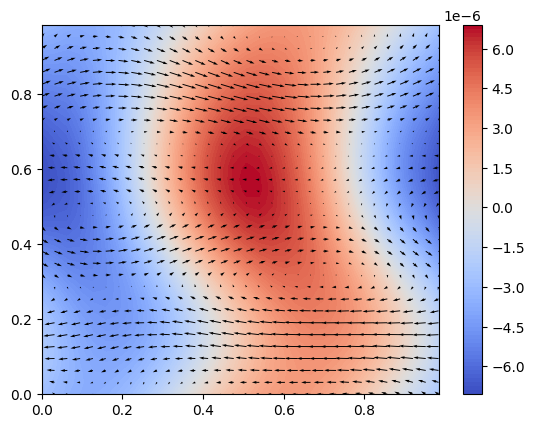

[[-7.02810605e-05  2.98417129e-06  5.73581111e-06 ...  2.69003865e-06
  -7.04295342e-05 -1.42689555e-04]
 [ 1.72997575e-04  2.13288083e-04  2.29603142e-04 ...  1.41037600e-04
   1.36689705e-04  1.38711233e-04]
 [ 1.63869947e-04  2.12801838e-04  2.28131845e-04 ...  1.35848985e-04
   1.25199448e-04  1.18555102e-04]
 ...
 [ 2.12379394e-04  2.67139796e-04  2.78431686e-04 ...  2.06106563e-04
   1.81706346e-04  1.62421847e-04]
 [ 1.96754957e-04  2.55114712e-04  2.65625590e-04 ...  1.91911204e-04
   1.64991566e-04  1.41518765e-04]
 [-7.51737009e-05  5.57851977e-06  7.20373130e-06 ...  5.43294104e-06
  -7.52467661e-05 -1.57134170e-04]]


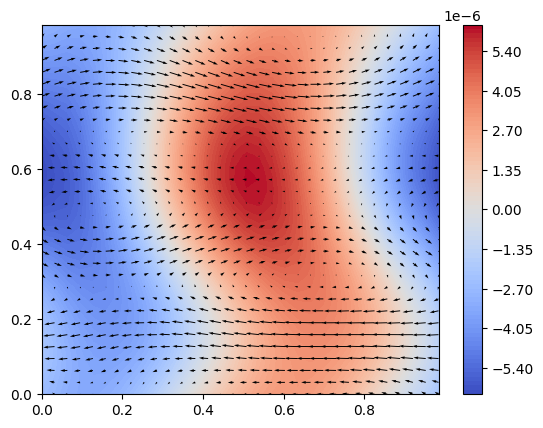

[[-6.59672836e-05  2.74195486e-06  5.32459003e-06 ...  2.47636456e-06
  -6.61013375e-05 -1.33854936e-04]
 [ 1.61988036e-04  1.99528733e-04  2.14310908e-04 ...  1.33961932e-04
   1.29040478e-04  1.30081758e-04]
 [ 1.54100166e-04  1.99783848e-04  2.13579826e-04 ...  1.30052271e-04
   1.19060058e-04  1.11832777e-04]
 ...
 [ 1.96256665e-04  2.46884250e-04  2.57149699e-04 ...  1.91225412e-04
   1.68286662e-04  1.50123617e-04]
 [ 1.82255130e-04  2.36345801e-04  2.45852072e-04 ...  1.78751137e-04
   1.53312527e-04  1.31105614e-04]
 [-7.02123803e-05  5.25531440e-06  6.77029180e-06 ...  5.13221314e-06
  -7.02742089e-05 -1.46790033e-04]]


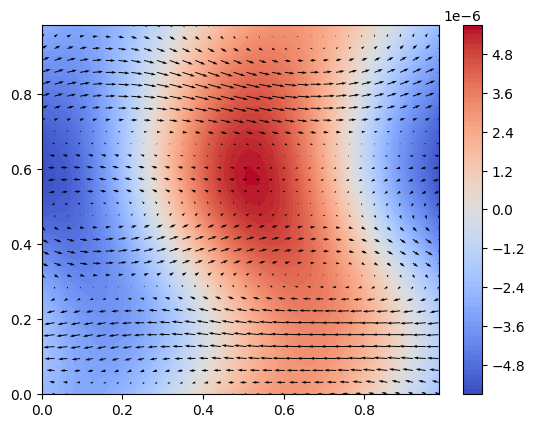

[[-6.18448008e-05  2.52038072e-06  4.94163306e-06 ...  2.27979872e-06
  -6.19662253e-05 -1.25425416e-04]
 [ 1.51544430e-04  1.86477980e-04  1.99868452e-04 ...  1.26988951e-04
   1.21652067e-04  1.21892211e-04]
 [ 1.44700343e-04  1.87287826e-04  1.99700616e-04 ...  1.24106793e-04
   1.12952956e-04  1.05332787e-04]
 ...
 [ 1.81445899e-04  2.28258661e-04  2.37589889e-04 ...  1.77505813e-04
   1.55942698e-04  1.38836528e-04]
 [ 1.68885424e-04  2.19010314e-04  2.27603517e-04 ...  1.66540996e-04
   1.42519805e-04  1.21526042e-04]
 [-6.55446462e-05  4.93782828e-06  6.35006831e-06 ...  4.83261778e-06
  -6.55975211e-05 -1.37047637e-04]]


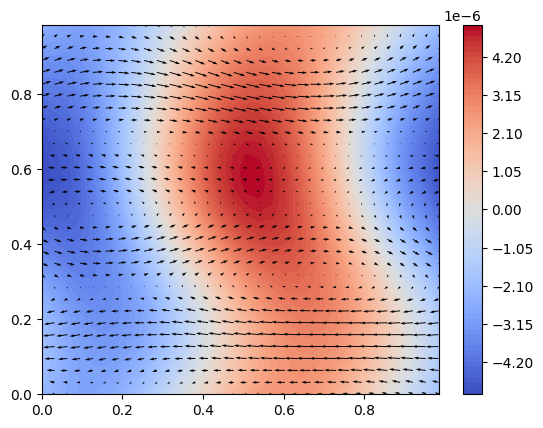

[[-5.79103709e-05  2.31772851e-06  4.58502458e-06 ...  2.09937507e-06
  -5.80205734e-05 -1.17391960e-04]
 [ 1.41640184e-04  1.74110820e-04  1.86239596e-04 ...  1.20142031e-04
   1.14522415e-04  1.14114195e-04]
 [ 1.35681734e-04  1.75330871e-04  1.86498302e-04 ...  1.18086850e-04
   1.06918337e-04  9.90616724e-05]
 ...
 [ 1.67789055e-04  2.11073520e-04  2.19555696e-04 ...  1.64795370e-04
   1.44535348e-04  1.28432788e-04]
 [ 1.56512980e-04  2.02950055e-04  2.10715638e-04 ...  1.55157924e-04
   1.32498576e-04  1.12672675e-04]
 [-6.11486435e-05  4.62832562e-06  5.94454377e-06 ...  4.53731400e-06
  -6.11944055e-05 -1.27864415e-04]]


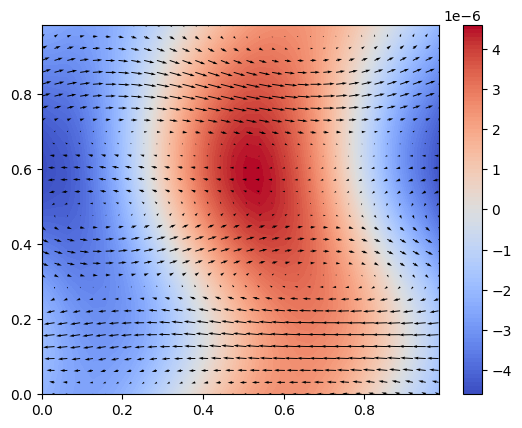

[[-5.41615088e-05  2.13233001e-06  4.25296026e-06 ...  1.93393403e-06
  -5.42616385e-05 -1.09747278e-04]
 [ 1.32254069e-04  1.62405077e-04  1.73391306e-04 ...  1.13445323e-04
   1.07653716e-04  1.06727194e-04]
 [ 1.27052417e-04  1.63923134e-04  1.73970594e-04 ...  1.12056287e-04
   1.00991401e-04  9.30262721e-05]
 ...
 [ 1.55161286e-04  1.95177949e-04  2.02889380e-04 ...  1.52978179e-04
   1.33957535e-04  1.18812638e-04]
 [ 1.45033295e-04  1.88039012e-04  1.95056067e-04 ...  1.44510250e-04
   1.23161781e-04  1.04462632e-04]
 [-5.70069391e-05  4.32864269e-06  5.55493880e-06 ...  4.24890085e-06
  -5.70470505e-05 -1.19206433e-04]]


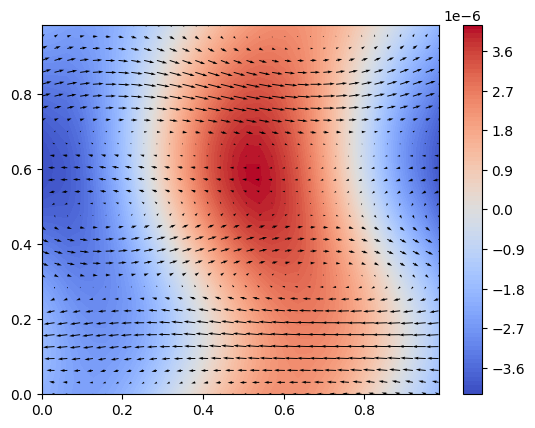

[[-5.05959041e-05  1.96261242e-06  3.94375559e-06 ...  1.78225502e-06
  -5.06869312e-05 -1.02484666e-04]
 [ 1.23368115e-04  1.51340011e-04  1.61292477e-04 ...  1.06921961e-04
   1.01050147e-04  9.97157645e-05]
 [ 1.18817262e-04  1.53068766e-04  1.62109931e-04 ...  1.06069327e-04
   9.52022767e-05  8.72327786e-05]
 ...
 [ 1.43462280e-04  1.80449676e-04  1.87462070e-04 ...  1.41964900e-04
   1.24125622e-04  1.09896969e-04]
 [ 1.34362743e-04  1.74174923e-04  1.80516146e-04 ...  1.34528745e-04
   1.14442520e-04  9.68309931e-05]
 [-5.31051916e-05  4.04021369e-06  5.18219402e-06 ...  3.96944735e-06
  -5.31407992e-05 -1.11045710e-04]]


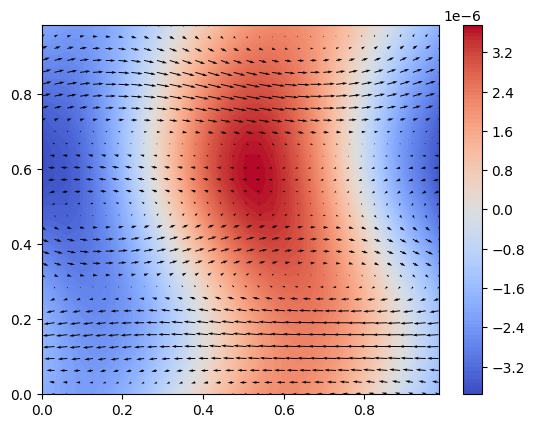

[[-4.72110551e-05  1.80712187e-06  3.65584768e-06 ...  1.64313698e-06
  -4.72938214e-05 -9.55972693e-05]
 [ 1.14966178e-04  1.40895411e-04  1.49913129e-04 ...  1.00592930e-04
   9.47163327e-05  9.30675611e-05]
 [ 1.10978061e-04  1.42766807e-04  1.50904428e-04 ...  1.00171452e-04
   8.95761598e-05  8.16861562e-05]
 ...
 [ 1.32609850e-04  1.66787640e-04  1.73166426e-04 ...  1.31685373e-04
   1.14973044e-04  1.01621842e-04]
 [ 1.24433035e-04  1.61273054e-04  1.67004878e-04 ...  1.25160156e-04
   1.06288414e-04  8.97259568e-05]
 [-4.94311960e-05  3.76410359e-06  4.82697089e-06 ...  3.70053612e-06
  -4.94631887e-05 -1.03358293e-04]]


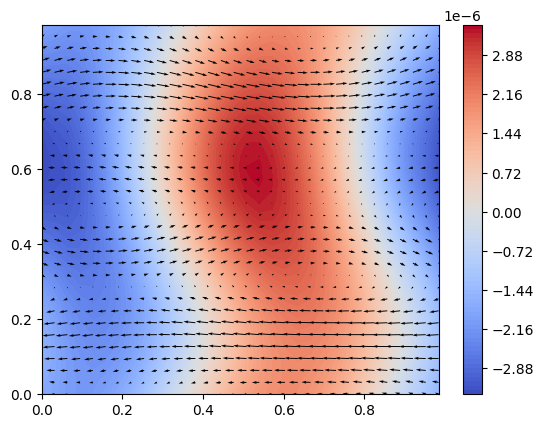

[[-4.40040511e-05  1.66453288e-06  3.38779195e-06 ...  1.51544407e-06
  -4.40793023e-05 -8.90776380e-05]
 [ 1.07032975e-04  1.31051038e-04  1.39223905e-04 ...  9.44763906e-05
   8.86563329e-05  8.67719565e-05]
 [ 1.03533737e-04  1.33011964e-04  1.40338695e-04 ...  9.44002535e-05
   8.41335691e-05  7.63898137e-05]
 ...
 [ 1.22535219e-04  1.54106543e-04  1.59911243e-04 ...  1.22083164e-04
   1.06445584e-04  9.39344521e-05]
 [ 1.15187151e-04  1.49261622e-04  1.54444469e-04 ...  1.16362445e-04
   9.86574455e-05  8.31052597e-05]
 [-4.59741975e-05  3.50104668e-06  4.48966636e-06 ...  3.44331597e-06
  -4.60032573e-05 -9.61228987e-05]]


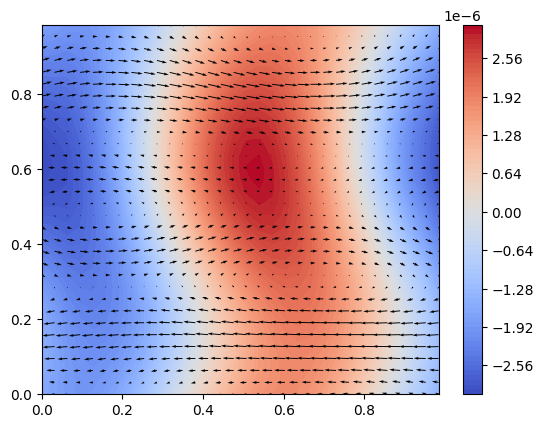

[[-4.09714594e-05  1.53364851e-06  3.13825518e-06 ...  1.39812857e-06
  -4.10398653e-05 -8.29174788e-05]
 [ 9.95534575e-05  1.21786298e-04  1.29195764e-04 ...  8.85873283e-05
   8.28730099e-05  8.08191054e-05]
 [ 9.64806018e-05  1.23795309e-04  1.30394529e-04 ...  8.87862443e-05
   7.88906673e-05  7.13454525e-05]
 ...
 [ 1.13179553e-04  1.42332864e-04  1.47617491e-04 ...  1.13111576e-04
   9.84979293e-05  8.67901559e-05]
 [ 1.06576347e-04  1.38078448e-04  1.42767056e-04 ...  1.08101310e-04
   9.15149196e-05  7.69335514e-05]
 [-4.27244043e-05  3.25148828e-06  4.17043675e-06 ...  3.19855885e-06
  -4.27510502e-05 -8.93199567e-05]]


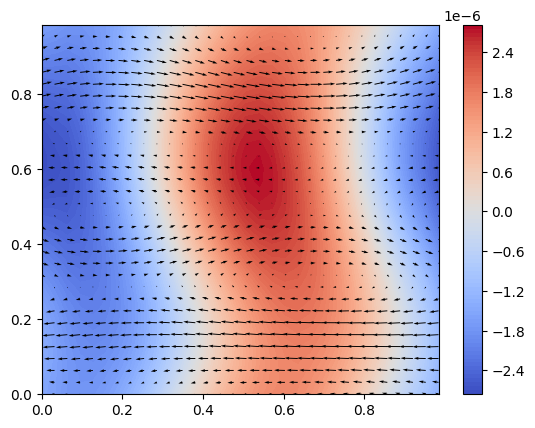

[[-3.81092839e-05  1.41339450e-06  2.90600657e-06 ...  1.29023925e-06
  -3.81714522e-05 -7.71075549e-05]
 [ 9.25124292e-05  1.13080094e-04  1.19799836e-04 ...  8.29374415e-05
   7.73676692e-05  7.51993309e-05]
 [ 8.98126426e-05  1.15104897e-04  1.21051512e-04 ...  8.33536213e-05
   7.38596236e-05  6.65530389e-05]
 ...
 [ 1.04491445e-04  1.31401955e-04  1.36215421e-04 ...  1.04730768e-04
   9.10911672e-05  8.01503176e-05]
 [ 9.85579837e-05  1.27668523e-04  1.31912320e-04 ...  1.00347692e-04
   8.48312631e-05  7.11804828e-05]
 [-3.96726491e-05  3.01562716e-06  3.86922688e-06 ...  2.96671709e-06
  -3.96972732e-05 -8.29309550e-05]]


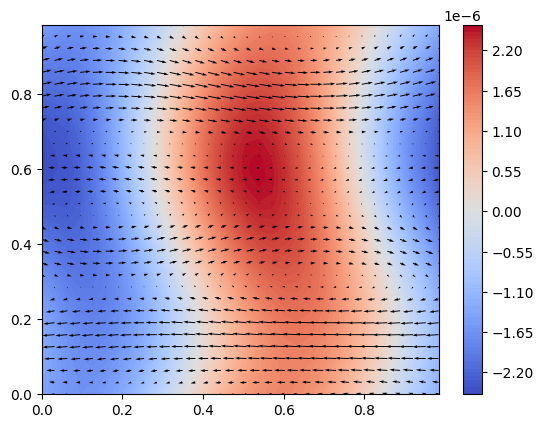

[[-3.54129759e-05  1.30281008e-06  2.68990808e-06 ...  1.19092091e-06
  -3.54694608e-05 -7.16376852e-05]
 [ 8.58943423e-05  1.04910790e-04  1.11007363e-04 ...  7.75351916e-05
   7.21399003e-05  6.99027490e-05]
 [ 8.35218143e-05  1.06926313e-04  1.12287523e-04 ...  7.81209852e-05
   6.90489974e-05  6.20108635e-05]
 ...
 [ 9.64250993e-05  1.21255940e-04  1.25642472e-04 ...  9.69057022e-05
   8.41909927e-05  7.39807557e-05]
 [ 9.10939606e-05  1.17982252e-04  1.21825759e-04 ...  9.30760060e-05
   7.85804583e-05  6.58193323e-05]
 [-3.68101614e-05  2.79345668e-06  3.58580137e-06 ...  2.74797809e-06
  -3.68330586e-05 -7.69380150e-05]]


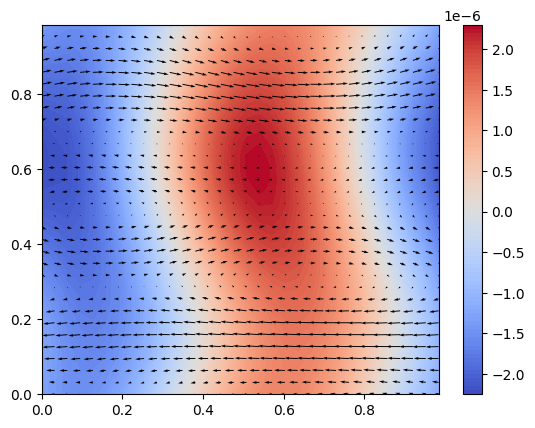

[[-3.28774769e-05  1.20103721e-06  2.48890487e-06 ...  1.09940892e-06
  -3.29287854e-05 -6.64968116e-05]
 [ 7.96832189e-05  9.72562663e-05  1.02789734e-04 ...  7.23859718e-05
   6.71875604e-05  6.49190650e-05]
 [ 7.75983383e-05  9.92431628e-05  1.04079191e-04 ...  7.31020150e-05
   6.44641308e-05  5.77156620e-05]
 ...
 [ 8.89390235e-05  1.11842215e-04  1.15841756e-04 ...  8.96047121e-05
   7.77664489e-05  6.82506374e-05]
 [ 8.41496040e-05  1.08974210e-04  1.12457446e-04 ...  8.62629237e-05
   7.27389480e-05  6.08260307e-05]
 [-3.41284215e-05  2.58480302e-06  3.31977587e-06 ...  2.54231459e-06
  -3.41498134e-05 -7.13236283e-05]]


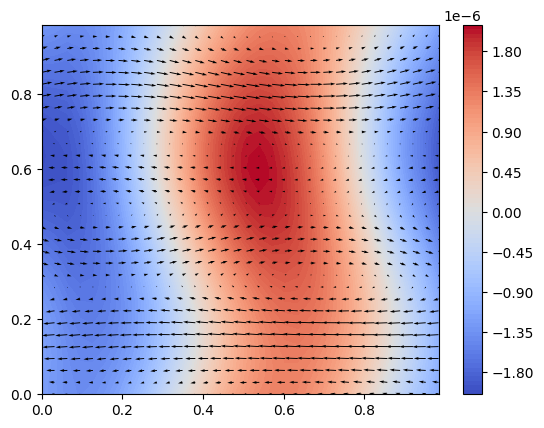

[[-3.04972843e-05  1.10730938e-06  2.30201636e-06 ...  1.01502121e-06
  -3.05438808e-05 -6.16731108e-05]
 [ 7.38626604e-05  9.00940212e-05  9.51185469e-05 ...  6.74923520e-05
   6.25068551e-05  6.02374915e-05]
 [ 7.20309926e-05  9.20375094e-05  9.64022774e-05 ...  6.83060979e-05
   6.01075386e-05  5.36627725e-05]
 ...
 [ 8.19951137e-05  1.03112372e-04  1.06760969e-04 ...  8.27985232e-05
   7.17890536e-05  6.29317022e-05]
 [ 7.76928846e-05  1.00602257e-04  1.03761143e-04 ...  7.98865620e-05
   6.72848883e-05  5.61784805e-05]
 [-3.16190747e-05  2.38935989e-06  3.07064664e-06 ...  2.34952937e-06
  -3.16391284e-05 -6.60705122e-05]]


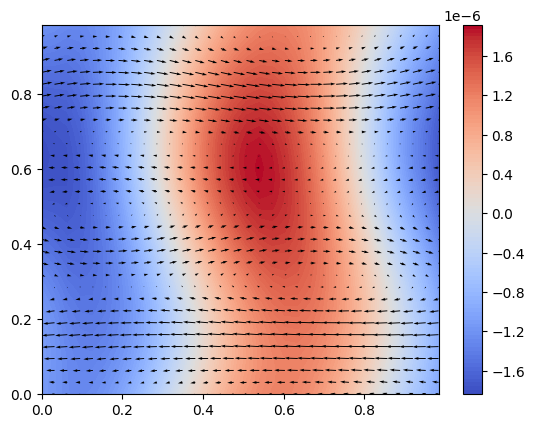

[[-2.82665280e-05  1.02094082e-06  2.12832833e-06 ...  9.37149388e-07
  -2.83088378e-05 -5.71541303e-05]
 [ 6.84159129e-05  8.34013080e-05  8.79657083e-05 ...  6.28543699e-05
   5.80924833e-05  5.58467503e-05]
 [ 6.68073907e-05  8.52902597e-05  8.92320175e-05 ...  6.37389160e-05
   5.59792872e-05  4.98463156e-05]
 ...
 [ 7.55580059e-05  9.50214474e-05  9.83516178e-05 ...  7.64596045e-05
   6.62322078e-05  5.79977237e-05]
 [ 7.16938784e-05  9.28269360e-05  9.56936774e-05 ...  7.39259602e-05
   6.21976550e-05  5.18560902e-05]
 [-2.92738882e-05  2.20671899e-06  2.83781768e-06 ...  2.16929426e-06
  -2.92927303e-05 -6.11615491e-05]]


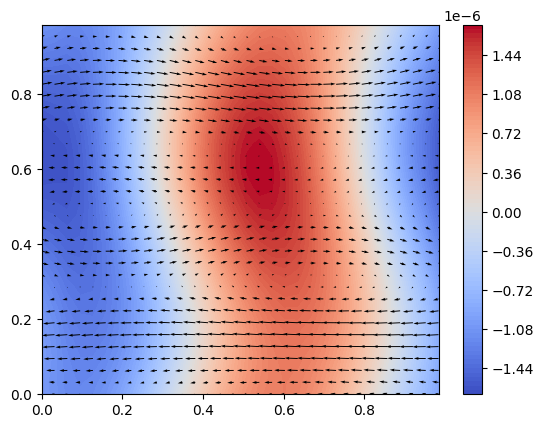

[[-2.61790514e-05  9.41316505e-07  1.96698601e-06 ...  8.65249817e-07
  -2.62174637e-05 -5.29269371e-05]
 [ 6.33259679e-05  7.71552861e-05  8.13035461e-05 ...  5.84698437e-05
   5.39378199e-05  5.17351277e-05]
 [ 6.19142427e-05  7.89815086e-05  8.25434132e-05 ...  5.94029855e-05
   5.20773555e-05  4.62593833e-05]
 ...
 [ 6.95946270e-05  8.75273896e-05  9.05684642e-05 ...  7.05617528e-05
   6.10708053e-05  5.34241414e-05]
 [ 6.61244001e-05  8.56110527e-05  8.82145061e-05 ...  6.83607674e-05
   5.74575297e-05  4.78394626e-05]
 [-2.70847368e-05  2.03639635e-06  2.62062475e-06 ...  2.00118325e-06
  -2.71024650e-05 -5.65797810e-05]]


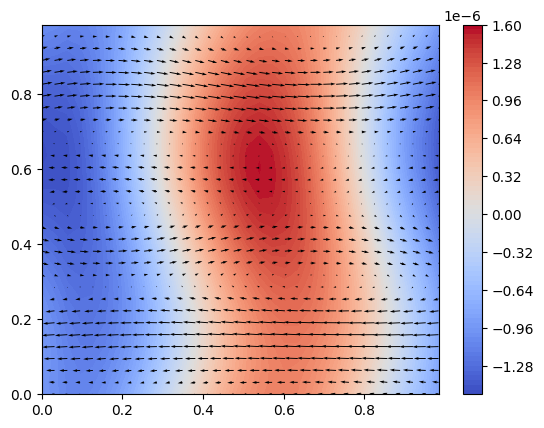

[[-2.42284928e-05  8.67883167e-07  1.81718823e-06 ...  7.98835334e-07
  -2.42633636e-05 -4.89782664e-05]
 [ 5.85756802e-05  7.13331750e-05  7.51049203e-05 ...  5.43346899e-05
   5.00351160e-05  4.78905625e-05]
 [ 5.73375955e-05  7.30908398e-05  7.63114833e-05 ...  5.52981512e-05
   4.83979726e-05  4.28942266e-05]
 ...
 [ 6.40738857e-05  8.05906907e-05  8.33691279e-05 ...  6.50798416e-05
   5.62809831e-05  4.91878133e-05]
 [ 6.09577594e-05  7.89193947e-05  8.12854065e-05 ...  6.31710738e-05
   5.30455131e-05  4.41101917e-05]
 [-2.50436088e-05  1.87785461e-06  2.41835629e-06 ...  1.84470029e-06
  -2.50603001e-05 -5.23084402e-05]]


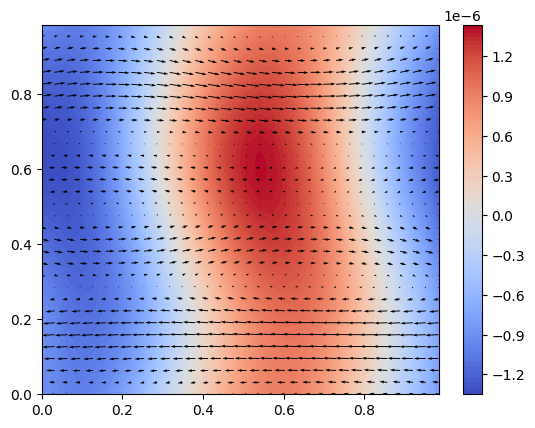

[[-2.24083631e-05  8.00141402e-07  1.67818263e-06 ...  7.37467771e-07
  -2.24400174e-05 -4.52946651e-05]
 [ 5.41478918e-05  6.59124025e-05  6.93433320e-05 ...  5.04432333e-05
   4.63757048e-05  4.43007519e-05]
 [ 5.30630513e-05  6.75975881e-05  7.05114779e-05 ...  5.14220336e-05
   4.49359296e-05  3.97424369e-05]
 ...
 [ 5.89664588e-05  7.41741264e-05  7.67138015e-05 ...  5.99896797e-05
   5.18399683e-05  4.52668511e-05]
 [ 5.61686013e-05  7.27185457e-05  7.48702644e-05 ...  5.83373404e-05
   4.89432246e-05  4.06507353e-05]
 [-2.31426229e-05  1.73052157e-06  2.23027120e-06 ...  1.69930212e-06
  -2.31583398e-05 -4.83310003e-05]]


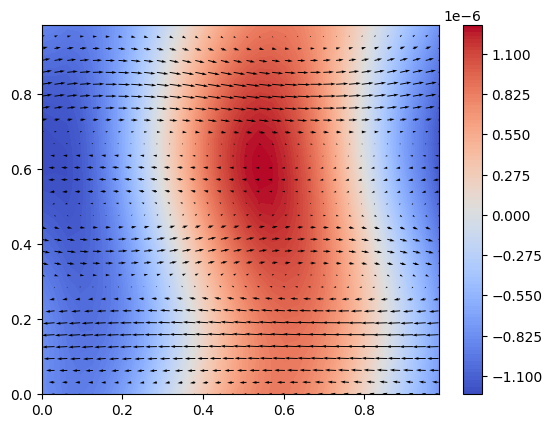

[[-2.07121169e-05  7.37638842e-07  1.54926150e-06 ...  6.80751427e-07
  -2.07408512e-05 -4.18626255e-05]
 [ 5.00255531e-05  6.08707421e-05  6.39930213e-05 ...  4.67884992e-05
   4.29502007e-05  4.09532611e-05]
 [ 4.90759611e-05  6.24810644e-05  6.51190581e-05 ...  4.77704303e-05
   4.16848620e-05  3.67951140e-05]
 ...
 [ 5.42446442e-05  6.82425720e-05  7.05650401e-05 ...  5.52679428e-05
   4.77259889e-05  4.16405114e-05]
 [ 5.17328043e-05  6.69767605e-05  6.89349222e-05 ...  5.38403899e-05
   4.51328583e-05  3.74443382e-05]
 [-2.13740523e-05  1.59380541e-06  2.05561366e-06 ...  1.56441681e-06
  -2.13888470e-05 -4.46312371e-05]]


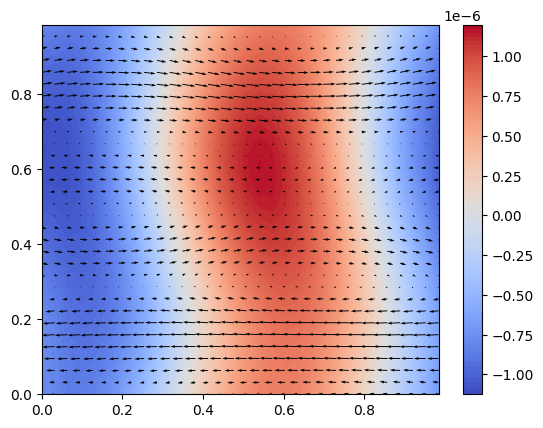

[[-1.91332166e-05  6.79964293e-07  1.42975857e-06 ...  6.28327445e-07
  -1.91593010e-05 -3.86687047e-05]
 [ 4.61918352e-05  5.61864351e-05  5.90290532e-05 ...  4.33624842e-05
   3.97486867e-05  3.78356323e-05]
 [ 4.53615948e-05  5.77207476e-05  6.01104440e-05 ...  4.43376734e-05
   3.86375033e-05  3.40430198e-05]
 ...
 [ 4.98822565e-05  6.27628696e-05  6.48876029e-05 ...  5.08921508e-05
   4.39182251e-05  3.82891242e-05]
 [ 4.76274140e-05  6.16638817e-05  6.34470689e-05 ...  4.96614366e-05
   4.15971743e-05  3.44749877e-05]
 [-1.97303501e-05  1.46710688e-06  1.89362533e-06 ...  1.43945857e-06
  -1.97442685e-05 -4.11932918e-05]]


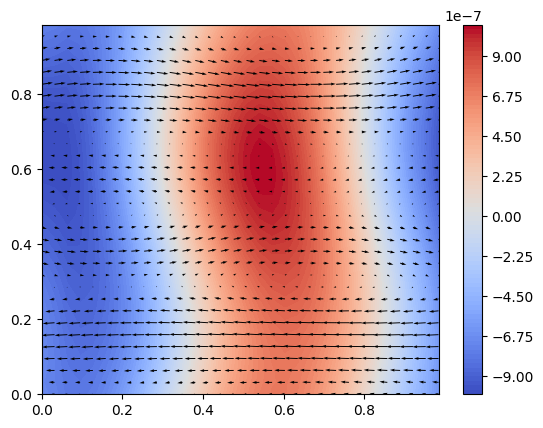

[[-1.76651883e-05  6.26742759e-07  1.31904611e-06 ...  5.79869055e-07
  -1.76888686e-05 -3.56996295e-05]
 [ 4.26302313e-05  5.18382953e-05  5.44273877e-05 ...  4.01564002e-05
   3.67608855e-05  3.49354856e-05]
 [ 4.19052875e-05  5.32964441e-05  5.54625353e-05 ...  4.11169439e-05
   3.57859088e-05  3.14767159e-05]
 ...
 [ 4.58545509e-05  5.77037262e-05  5.96483283e-05 ...  4.68406697e-05
   4.03967857e-05  3.51940433e-05]
 [ 4.38306013e-05  5.67512814e-05  5.83761557e-05 ...  4.57821349e-05
   3.83195100e-05  3.17273904e-05]
 [-1.82041755e-05  1.34982905e-06  1.74355506e-06 ...  1.32383935e-06
  -1.82172586e-05 -3.80017309e-05]]


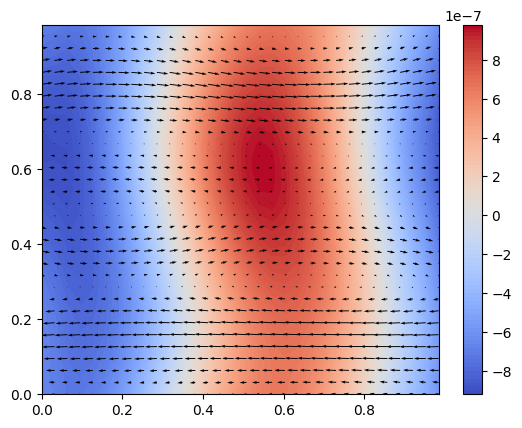

[[-1.63016697e-05  5.77631219e-07  1.21653269e-06 ...  5.35077564e-07
  -1.63231693e-05 -3.29423863e-05]
 [ 3.93246442e-05  4.78057974e-05  5.01649364e-05 ...  3.71608916e-05
   3.39763124e-05  3.22406098e-05]
 [ 3.86925637e-05  4.91884194e-05  5.11530061e-05 ...  3.81005457e-05
   3.31216516e-05  2.90866828e-05]
 ...
 [ 4.21381637e-05  5.30356332e-05  5.48160307e-05 ...  4.30927280e-05
   3.71426971e-05  3.23376112e-05]
 [ 4.03216327e-05  5.22118172e-05  5.36933284e-05 ...  4.21846366e-05
   3.52838018e-05  2.91869595e-05]
 [-1.67884170e-05  1.24138480e-06  1.60466671e-06 ...  1.21697781e-06
  -1.68007031e-05 -3.50415998e-05]]


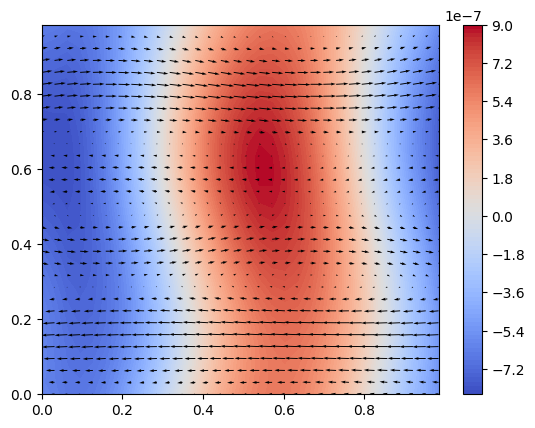

[[-1.50364500e-05  5.32315057e-07  1.12166109e-06 ...  4.93679005e-07
  -1.50559720e-05 -3.03842959e-05]
 [ 3.62594592e-05  4.40691471e-05  4.62196033e-05 ...  3.43662256e-05
   3.13844080e-05  2.97390416e-05]
 [ 3.57092400e-05  4.53775042e-05  4.71603772e-05 ...  3.52801431e-05
   3.06359918e-05  2.68634235e-05]
 ...
 [ 3.87110620e-05  4.87307960e-05  5.03614111e-05 ...  3.96284353e-05
   3.41378978e-05  2.97031307e-05]
 [ 3.70808467e-05  4.80197949e-05  4.93713676e-05 ...  3.88516476e-05
   3.24746092e-05  2.68398079e-05]
 [-1.54762128e-05  1.14120253e-06  1.47624497e-06 ...  1.11830613e-06
  -1.54877383e-05 -3.22984692e-05]]


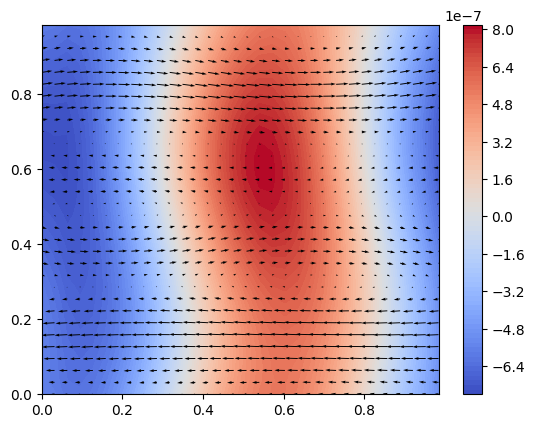

[[-1.38635023e-05  4.90505040e-07  1.03390662e-06 ...  4.55421335e-07
  -1.38812309e-05 -2.80130738e-05]
 [ 3.34196034e-05  4.06093357e-05  4.25703127e-05 ...  3.17624557e-05
   2.89746525e-05  2.74191320e-05]
 [ 3.29415089e-05  4.18451772e-05  4.34640687e-05 ...  3.26469637e-05
   2.83200201e-05  2.47975507e-05]
 ...
 [ 3.55524989e-05  4.47630706e-05  4.62569741e-05 ...  3.64288004e-05
   3.13652348e-05  2.72748397e-05]
 [ 3.40896333e-05  4.41509336e-05  4.53846338e-05 ...  3.57664794e-05
   2.98771366e-05  2.46727428e-05]
 [-1.42609677e-05  1.04873043e-06  1.35759988e-06 ...  1.02727492e-06
  -1.42717677e-05 -2.97584716e-05]]


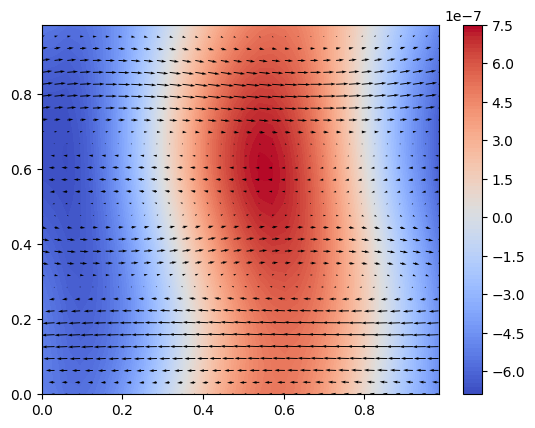

[[-1.27770087e-05  4.51934746e-07  9.52775538e-07 ...  4.20072089e-07
  -1.27931110e-05 -2.58168777e-05]
 [ 3.07905914e-05  3.74081786e-05  3.91970236e-05 ...  2.93395606e-05
   2.67366622e-05  2.52696007e-05]
 [ 3.03760052e-05  3.85736272e-05  4.00444352e-05 ...  3.01919697e-05
   2.61647793e-05  2.28798581e-05]
 ...
 [ 3.26429689e-05  4.11079022e-05  4.24769510e-05 ...  3.34757440e-05
   2.88084562e-05  2.50378861e-05]
 [ 3.13304120e-05  4.05823301e-05  4.17090130e-05 ...  3.29130929e-05
   2.74772524e-05  2.26732595e-05]
 [-1.31363656e-05  9.63439407e-07  1.24806993e-06 ...  9.43356797e-07
  -1.31464744e-05 -2.74083289e-05]]


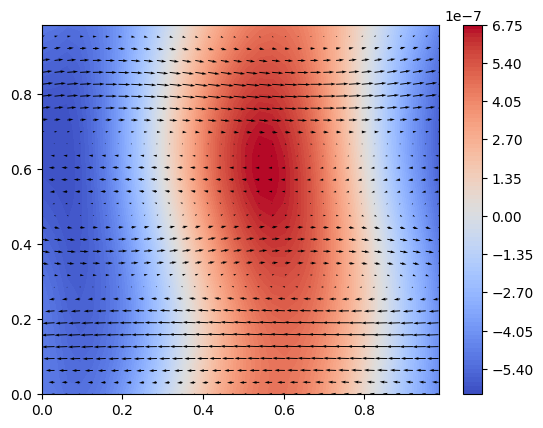

[[-1.17713799e-05  4.16358369e-07  8.77803570e-07 ...  3.87416410e-07
  -1.17860073e-05 -2.37843428e-05]
 [ 2.83585583e-05  3.44483411e-05  3.60807335e-05 ...  2.70875604e-05
   2.46602675e-05  2.32795784e-05]
 [ 2.79998569e-05  3.55457989e-05  3.68827861e-05 ...  2.79060024e-05
   2.41613650e-05  2.11013795e-05]
 ...
 [ 2.99641648e-05  3.77422641e-05  3.89972237e-05 ...  3.07521051e-05
   2.64522019e-05  2.29783018e-05]
 [ 2.87866079e-05  3.72924206e-05  3.83218622e-05 ...  3.02761319e-05
   2.52615006e-05  2.08295331e-05]
 [-1.20963782e-05  8.84825087e-07  1.14702422e-06 ...  8.66048702e-07
  -1.21058294e-05 -2.52353722e-05]]


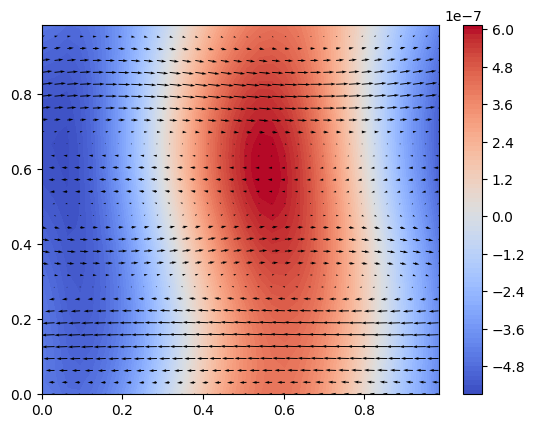

[[-1.08412686e-05  3.83548834e-07  8.08554621e-07 ...  3.57255387e-07
  -1.08545586e-05 -2.19046069e-05]
 [ 2.61102826e-05  3.17133521e-05  3.32034722e-05 ...  2.49966120e-05
   2.27355770e-05  2.14386396e-05]
 [ 2.58007222e-05  3.27454218e-05  3.39613929e-05 ...  2.57799009e-05
   2.23010075e-05  1.94534343e-05]
 ...
 [ 2.74989323e-05  3.46445965e-05  3.57952497e-05 ...  2.82416399e-05
   2.42819884e-05  2.10829751e-05]
 [ 2.64426253e-05  3.42609404e-05  3.52019536e-05 ...  2.78409481e-05
   2.32171073e-05  1.91304067e-05]
 [-1.11352706e-05  8.12409010e-07  1.05386371e-06 ...  7.94873350e-07
  -1.11440972e-05 -2.32275525e-05]]


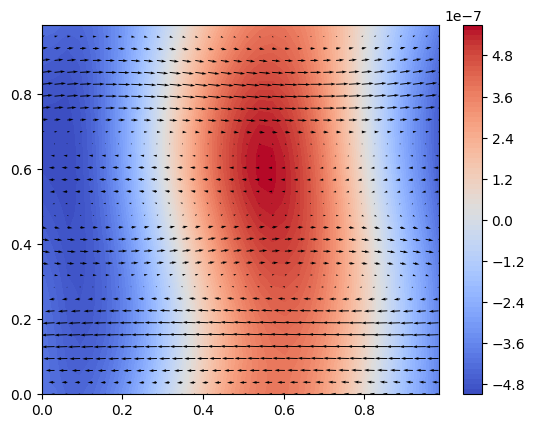

[[-9.98157869e-06  3.53296165e-07  7.44619466e-07 ...  3.29404636e-07
  -9.99365559e-06 -2.01673257e-05]
 [ 2.40331979e-05  2.91876066e-05  3.05482868e-05 ...  2.30570864e-05
   2.09530266e-05  1.97368241e-05]
 [ 2.37668153e-05  3.01570271e-05  3.12634865e-05 ...  2.38045993e-05
   2.05751378e-05  1.79276624e-05]
 ...
 [ 2.52312236e-05  3.17947437e-05  3.28499881e-05 ...  2.59290141e-05
   2.22841903e-05  1.93396212e-05]
 [ 2.42838180e-05  3.14688793e-05  3.23294172e-05 ...  2.55936154e-05
   2.13319807e-05  1.75653777e-05]
 [-1.02476028e-05  7.45739169e-07  9.68021851e-07 ...  7.29379929e-07
  -1.02558371e-05 -2.13734445e-05]]


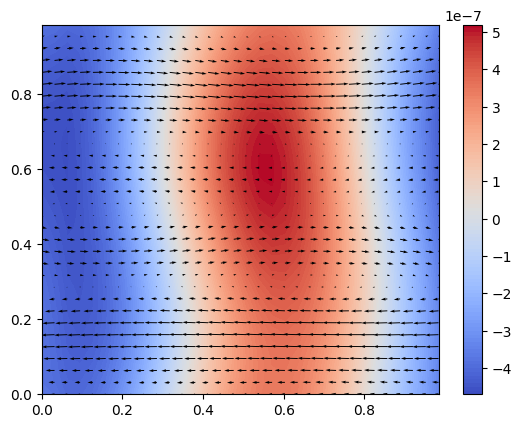

[[-9.18746977e-06  3.25406054e-07  6.85614525e-07 ...  3.03693079e-07
  -9.19844631e-06 -1.85626809e-05]
 [ 2.21153971e-05  2.68563604e-05  2.80992205e-05 ...  2.12596291e-05
   1.93034174e-05  1.81646518e-05]
 [ 2.18869210e-05  2.77659533e-05  2.87732448e-05 ...  2.19712053e-05
   1.89754396e-05  1.65160504e-05]
 ...
 [ 2.31460501e-05  2.91738908e-05  3.01418258e-05 ...  2.37997880e-05
   2.04460173e-05  1.77367499e-05]
 [ 2.22964570e-05  2.88984348e-05  2.96856822e-05 ...  2.35209363e-05
   1.95947055e-05  1.61245798e-05]
 [-9.42822876e-06  6.84390073e-07  8.88964572e-07 ...  6.69144253e-07
  -9.43590260e-06 -1.96622443e-05]]


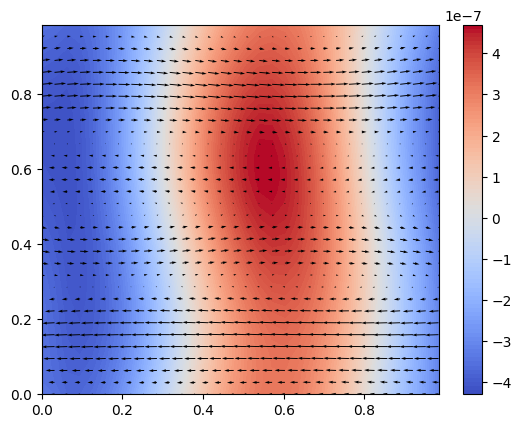

[[-8.45435864e-06  2.99698605e-07  6.31180657e-07 ...  2.79961888e-07
  -8.46433691e-06 -1.70813811e-05]
 [ 2.03456293e-05  2.47057168e-05  2.58412849e-05 ...  1.95952070e-05
   1.77779421e-05  1.67131292e-05]
 [ 2.01504024e-05  2.55583429e-05  2.64757738e-05 ...  2.02710611e-05
   1.74938883e-05  1.52109481e-05]
 ...
 [ 2.12294333e-05  2.67644995e-05  2.76525032e-05 ...  2.18403966e-05
   1.87554870e-05  1.62636330e-05]
 [ 2.04676955e-05  2.65329625e-05  2.72534169e-05 ...  2.16104399e-05
   1.79945316e-05  1.47987633e-05]
 [-8.67229299e-06  6.27962413e-07  8.16189948e-07 ...  6.13768476e-07
  -8.67943733e-06 -1.80837613e-05]]


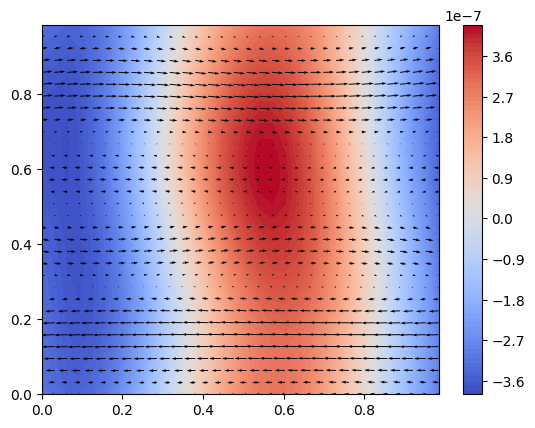

[[-7.77791768e-06  2.76007214e-07  5.80981985e-07 ...  2.58063548e-07
  -7.78699014e-06 -1.57146574e-05]
 [ 1.87132905e-05  2.27226071e-05  2.37604282e-05 ...  1.80551428e-05
   1.63682030e-05  1.53737499e-05]
 [ 1.85471995e-05  2.35211305e-05  2.43570825e-05 ...  1.86957911e-05
   1.61227802e-05  1.40050796e-05]
 ...
 [ 1.94683555e-05  2.45502431e-05  2.53650423e-05 ...  2.00381242e-05
   1.72013960e-05  1.49102695e-05]
 [ 1.87855324e-05  2.43569251e-05  2.50164685e-05 ...  1.98503736e-05
   1.65213593e-05  1.35792730e-05]
 [-7.97522464e-06  5.76082459e-07  7.49227463e-07 ...  5.62880500e-07
  -7.98186964e-06 -1.66284062e-05]]


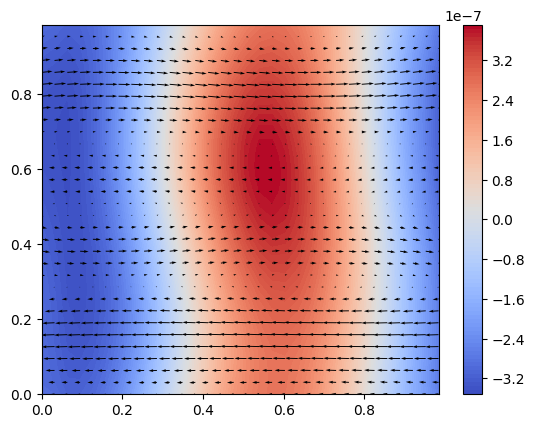

In [14]:
for i in range(N_ITERATIONS):
  u_i = u_intermediate(u_prev, v_prev)
  v_i = v_intermediate(u_prev, v_prev)

  p_prev = p_update(u_i, v_i, p_prev)

  u_prev = u_update(u_i, p_prev)
  v_prev = v_update(v_i, p_prev) 

  if np.all(d_dx(u_prev) + d_dy(v_prev) != 0) and i % 10 == 0:
    print(d_dx(u_prev) + d_dy(v_prev))

  if i % 10 == 0:
    plt.figure()
    plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], 100, cmap="coolwarm")
    plt.colorbar()

    plt.quiver(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2])

    plt.show()

    plt.close()
    
#     plt.savefig(f'img_{int(i/10)}.png',
#                 transparent = False,  
#                 facecolor = 'white'
#                )
    
#     plt.close()
    
# frames = []
# for i in range(int(N_ITERATIONS / 10)):
#   image = imageio.v2.imread(f'img_{int(i/10)}.png')
#   frames.append(image)

# imageio.mimsave('./example.gif', # output gif
#                 frames,          # array of input frames
#                 fps = 5)         # optional: frames per second

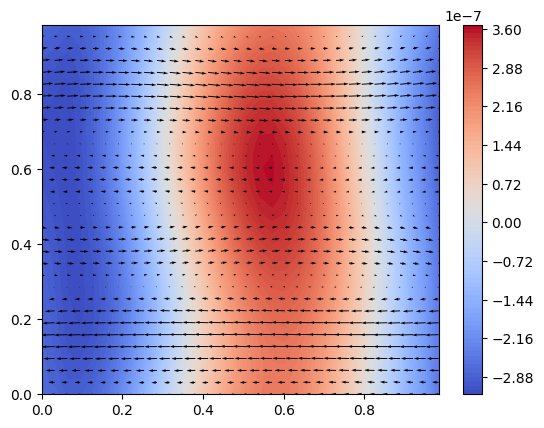

In [15]:
# The [::2, ::2] selects only every second entry (less cluttering plot)
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], 100, cmap="coolwarm")
plt.colorbar()

plt.quiver(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2], color="black")
plt.show()